In [1]:
import sys; sys.path.append('/Users/uvc/Documents/Projects/qnlp/qlstm')
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [351]:
BATCH_SIZE = 10
EPOCHS = 100
SEED = 2

In [352]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences

train_labels, train_data = read_data('../Datasets/mc_train_data.txt')
val_labels, val_data = read_data('../Datasets/mc_test_data.txt')
test_labels, test_data = read_data('../Datasets/mc_test_data.txt')

In [353]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('S', 'N'), verbose='text')

In [354]:
raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


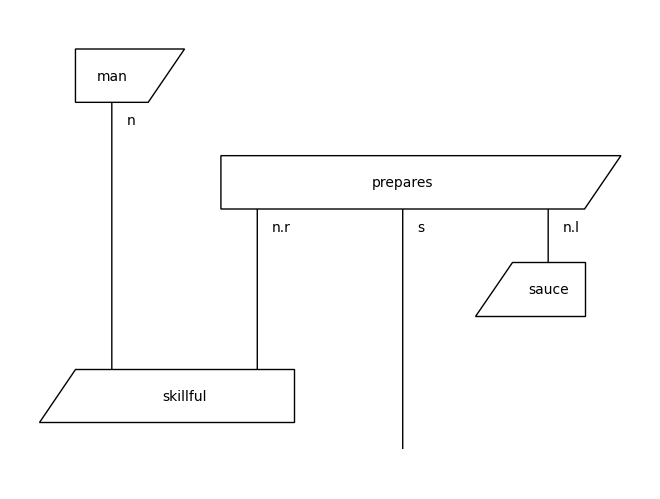

In [355]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
val_diagrams = [remove_cups(diagram) for diagram in raw_val_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

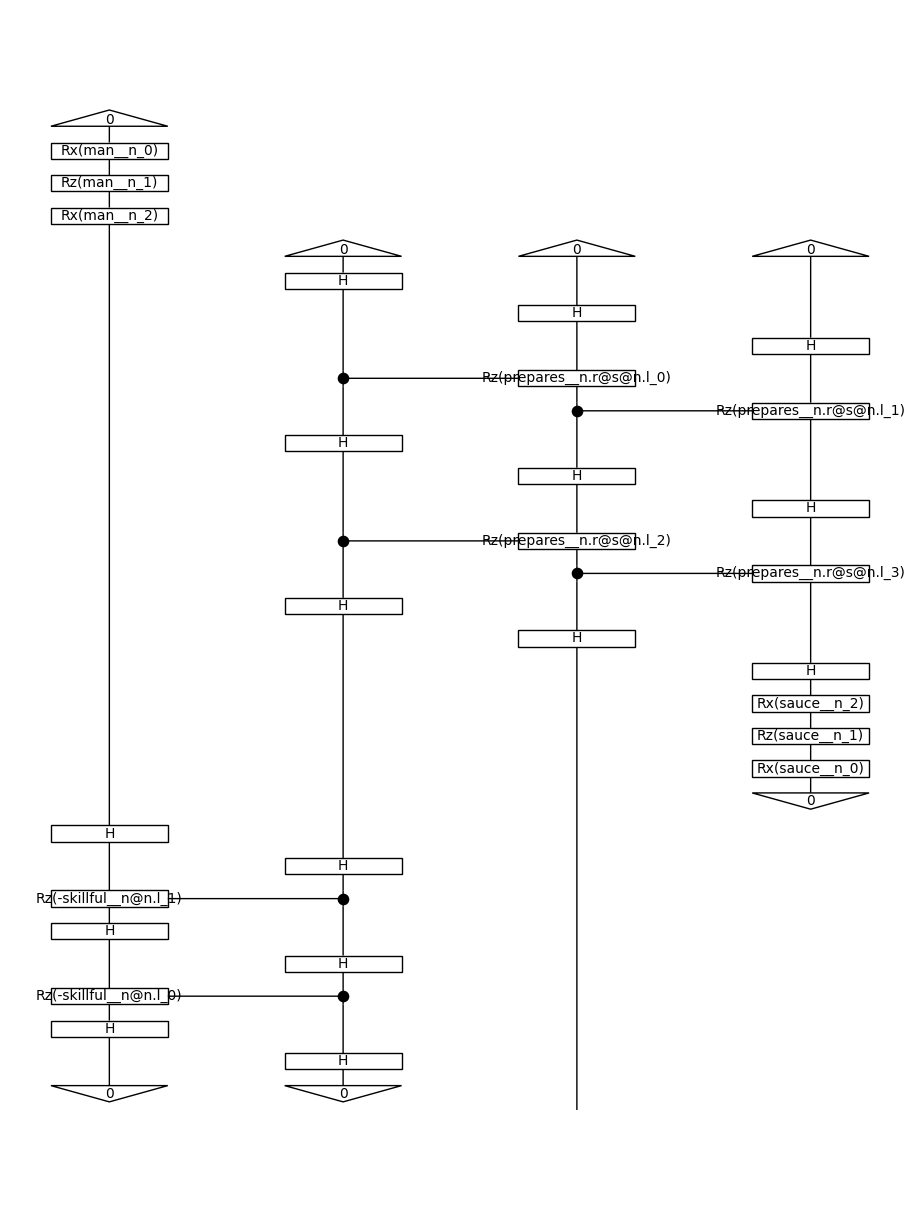

In [368]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=2, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
val_circuits =  [ansatz(diagram) for diagram in val_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 12))

In [369]:
from pytket.qasm import circuit_to_qasm_str
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit

for inst in tk_to_qiskit(train_circuits[0].to_tk()):
    print(inst.operation.name.upper())

RX
H
H
H
RZ
CRZ
RX
H
CRZ
H
H
H
CRZ
H
CRZ
H
H
H
CRZ
RX
H
H
RZ
CRZ
RX
MEASURE
H
H
MEASURE
MEASURE


In [370]:
tensor = [0,0]
measured_qubits = []
qubit = 0
circ = tk_to_qiskit(train_circuits[0].to_tk())
num_wires = circ.data[0].qubits[0].register.size
q_dev = qml.device('default.qubit', wires=['wire{}'.format(i) for i in range(num_wires)])
qc = qml.from_qiskit(circ)

/var/folders/x8/4nwfzz4d2tb_w79xcl4k8gxxn0kqjv/T/ipykernel_9182/2856226092.py:5: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.register`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  num_wires = circ.data[0].qubits[0].register.size


In [371]:
from __future__ import annotations

from collections.abc import Callable
from typing import Any

from discopy.quantum import Circuit, Id, Measure
from discopy.tensor import Diagram
import numpy as np

from lambeq.training.quantum_model import QuantumModel

import pennylane as qml

class TketModel(QuantumModel):
    """Model based on `tket`.

    This can run either shot-based simulations of a quantum
    pipeline or experiments run on quantum hardware using `tket`.

    """

    def __init__(self, backend_config: dict[str, Any]) -> None:
        """Initialise TketModel based on the `t|ket>` backend.

        Other Parameters
        ----------------
        backend_config : dict
            Dictionary containing the backend configuration. Must
            include the fields `backend`, `compilation` and `shots`.

        Raises
        ------
        KeyError
            If `backend_config` is not provided or has missing fields.

        """
        super().__init__()

        fields = ('backend', 'compilation', 'shots')
        missing_fields = [f for f in fields if f not in backend_config]
        if missing_fields:
            raise KeyError('Missing arguments in backend configuation. '
                           f'Missing arguments: {missing_fields}.')
        self.backend_config = backend_config

    '''
    def _make_lambda(self, diagram: Diagram) -> Callable[..., Any]:
        """Measure and lambdify diagrams."""
        measured = diagram >> Id().tensor(*[Measure()] * len(diagram.cod))
        ret: Callable = measured.lambdify(*self.symbols)
        return ret

    def _randint(self, low: int = -1 << 63, high: int = (1 << 63)-1) -> int:
        return np.random.randint(low, high, dtype=np.int64)
    '''

    def get_diagram_output(self, diagrams: list[Diagram]) -> np.ndarray:
        """Return the prediction for each diagram using t|ket>.

        Parameters
        ----------
        diagrams : list of :py:class:`~discopy.tensor.Diagram`
            The :py:class:`Circuits <discopy.quantum.circuit.Circuit>`
            to be evaluated.

        Raises
        ------
        ValueError
            If `model.weights` or `model.symbols` are not initialised.

        Returns
        -------
        np.ndarray
            Resulting array.

        """
        if len(self.weights) == 0 or not self.symbols:
            raise ValueError('Weights and/or symbols not initialised. '
                             'Instantiate through '
                             '`TketModel.from_diagrams()` first, '
                             'then call `initialise_weights()`, or load '
                             'from pre-trained checkpoint.')

        '''
        lambdified_diagrams = [self._make_lambda(d) for d in diagrams]
        tensors = Circuit.eval(
            *[diag_f(*self.weights) for diag_f in lambdified_diagrams],
            **self.backend_config,
            seed=self._randint()
        )
        '''

        qiskit_weights = dict(zip([str(symbol) for symbol in [*self.symbols]], [*self.weights]))
        # print(qiskit_weights.keys())

        tensors = []
        for i, d in enumerate(diagrams):
            tensor = [0,0]
            measured_qubits = []
            qubit = 0
            circ = tk_to_qiskit(d.to_tk())
            num_wires = circ.data[0].qubits[0].register.size
            wires = [i for i in range(num_wires)]
            '''
            q_dev = tq.QuantumDevice(n_wires=num_wires)
            q_dev.reset_states(bsz=1)
            '''
            q_dev = qml.device('default.qubit', wires=wires)
            for inst in circ.data:
                if inst.operation.name == 'measure':
                    measured_qubits.append(*[qubit.index for qubit in inst.qubits])
            '''
                    continue
                if len(inst.operation.params)==0:
                    eval('tqf.{}(q_dev, wires={})'.format(inst.operation.name,
                                                          [qubit.index for qubit in inst.qubits]))
                else:
                    eval('tqf.{}(q_dev, wires={}, params=[{}])'.format(inst.operation.name,
                                                          [qubit.index for qubit in inst.qubits],
                                                          2*np.pi*qiskit_weights[str(inst.operation.params[0])[5:]]))
            @qml.qnode(q_dev)
            def qc(qiskit_circ, wires):
                qml.from_qiskit(qiskit_circ)
                return qml.probs(wires=wires)
            '''
            @qml.qnode(q_dev)
            def qc(qiskit_circ, wires):
                for inst in qiskit_circ.data:
                    if inst.operation.name == 'measure': continue
                    if len(inst.operation.params)==0:
                        if inst.operation.name=='h':
                            eval('qml.Hadamard(wires={})'.format([qubit.index for qubit in inst.qubits]))
                        else:
                            eval('qml.{}(wires={})'.format(inst.operation.name.upper(), [qubit.index for qubit in inst.qubits]))
                    else:
                        # print(str(inst.operation.params[0]))
                        if str(inst.operation.params[0])[0] == '-':
                            eval('qml.{}(phi={}, wires={})'.format(inst.operation.name.upper(),
                                                               2*np.pi*qiskit_weights[str(inst.operation.params[0])[6:]],
                                                               [qubit.index for qubit in inst.qubits]))
                        else:
                            eval('qml.{}(phi={}, wires={})'.format(inst.operation.name.upper(),
                                                               2*np.pi*qiskit_weights[str(inst.operation.params[0])[5:]],
                                                               [qubit.index for qubit in inst.qubits]))
                            
                return qml.probs(wires=wires)

            # measured_qubits= np.array(measured_qubits)
            for j in range(num_wires):
                if j not in measured_qubits: qubit = j
            '''
            measures = tq.measure(q_dev, n_shots=backend_config['shots'])[0]
            for key in measures.keys():
                if np.all(np.array([*key])[measured_qubits] == '0'):
                    tensor[int(np.array([*key])[qubit])] = measures[key]/backend_config['shots']
            tensors.append(np.array(tensor))
            '''
            measures = qc(circ, wires)
            # print(num_wires, j, measures)
            indices = np.array([pow(2,num_wires)-1-pow(2,j), pow(2,num_wires)-1])
            for i in range(2): tensor[i] = measures[indices[i]]
            tensors.append(np.array(tensor))
        
        self.backend_config['backend'].empty_cache()
        # discopy evals a single diagram into a single result
        # and not a list of results
        if len(diagrams) == 1:
            result = self._normalise_vector(tensors.array)
            return result.reshape(1, *result.shape)
        # return np.array([self._normalise_vector(t.array) for t in tensors])
        return np.array([self._normalise_vector(t) for t in tensors])

    def forward(self, x: list[Diagram]) -> np.ndarray:
        """Perform default forward pass of a lambeq quantum model.

        In case of a different datapoint (e.g. list of tuple) or
        additional computational steps, please override this method.

        Parameters
        ----------
        x : list of :py:class:`~discopy.tensor.Diagram`
            The :py:class:`Circuits <discopy.quantum.circuit.Circuit>`
            to be evaluated.

        Returns
        -------
        np.ndarray
            Array containing model's prediction.

        """
        return self.get_diagram_output(x)

In [372]:
from pytket.extensions.qiskit import AerBackend

all_circuits = train_circuits+val_circuits+test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

In [373]:
from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

In [374]:
# bce = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
# # myloss = lambda y_hat, y: -np.sum(y * np.log(y_hat) + (1-y) * np.log(1-y_hat)) / len(y) / 2 # my binary cross-entropy loss

# acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
# eval_metrics = {"acc": acc}

In [379]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [380]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

In [381]:
trainer.fit(train_dataset, val_dataset, log_interval=12)

/var/folders/x8/4nwfzz4d2tb_w79xcl4k8gxxn0kqjv/T/ipykernel_9182/4278328341.py:102: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.register`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  num_wires = circ.data[0].qubits[0].register.size
/var/folders/x8/4nwfzz4d2tb_w79xcl4k8gxxn0kqjv/T/ipykernel_9182/4278328341.py:111: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  measured_qubits.append(*[qubit.index for qubit in inst.qubits])
/var/folders/x8/4n

/var/folders/x8/4nwfzz4d2tb_w79xcl4k8gxxn0kqjv/T/ipykernel_9182/4278328341.py:102: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.register`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  num_wires = circ.data[0].qubits[0].register.size
/var/folders/x8/4nwfzz4d2tb_w79xcl4k8gxxn0kqjv/T/ipykernel_9182/4278328341.py:111: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  measured_qubits.append(*[qubit.index for qubit in inst.qubits])
/var/folders/x8/4n

Test accuracy: 0.8666666666666667


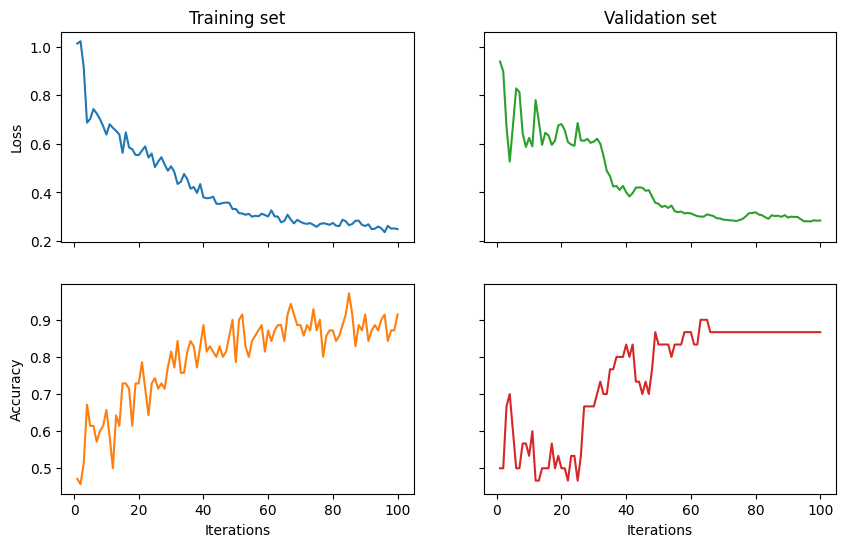

In [383]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Validation set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)